In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import os, re
import matplotlib.pyplot as plt

from collections import Counter
from torch.utils.data import Dataset, DataLoader

import warnings

#### Download dataset

In [ ]:
import kagglehub
path = kagglehub.dataset_download("pranayprasad/aclimdb")

#### Pre-processing text

In [37]:
import nltk
#nltk.download('stopwords') 
from nltk.corpus import stopwords
stopwords = set(stopwords.words("english"))

In [38]:
def pre_process_text(all_files):
    all_words, seq_len = [], []
    for f_name in all_files:
        text = open(f_name).readlines()[0].lower()
        text = re.sub ( r'[^\w\s]', '', text)
        words = text.split(" ")
        words = [w for w in words if (w not in stopwords) and (len(w) >=0) ]
        all_words+=words
        seq_len.append(len(words))
    return (all_words, seq_len)

train_dir = "../data/aclImdb/train"

all_files = ([ os.path.join ( train_dir,  f"pos/{f_name}") for f_name in  os.listdir(f"{train_dir}/pos")] + 
             [ os.path.join ( train_dir,  f"neg/{f_name}") for f_name in  os.listdir(f"{train_dir}/neg")] )

train_words, sentence_len = pre_process_text(all_files)

In [39]:
f"avg sentence length: {np.mean(sentence_len)}"

'avg sentence length: 125.16576'

#### Creating Tokenizer

In [40]:
bog = dict(Counter(train_words))
words = sorted([key for (key,value) in bog.items() if value > 500])

words.append("<UNK>")
words.append("<PAD>")

w2i = {w: i for i, w in enumerate(words)}
i2w = {i: w for i, w in enumerate(words)}

#### Defining Dataloader

In [44]:
class IMDBDataLoader(Dataset):
    def __init__(self, data_path, tokenizer, max_seq_len = 200):
        self.tokenizer = w2i
        self.max_seq_len = max_seq_len
        self.data_files = ([ os.path.join ( data_path,  f"pos/{f_name}") for f_name in  os.listdir(f"{data_path}/pos")] + 
             [ os.path.join ( data_path,  f"neg/{f_name}") for f_name in  os.listdir(f"{data_path}/neg")] )

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        file_path = self.data_files[idx]

        def get_sample(f_name):
            text = open(f_name).readlines()[0].lower()
            text = re.sub ( r'[^\w\s]', '', text)
            words = text.split(" ")
            return [w for w in words if (w not in stopwords) and (len(w) >=0) ]

        def get_tokenzied_sample_seq(f_name):
            sample = get_sample(f_name)
            # if more than seq_len, trim it
            if len(sample) > self.max_seq_len:
                rand_start_idx = np.random.randint( (len(sample) - self.max_seq_len) )
                sample = sample[rand_start_idx: (rand_start_idx + self.max_seq_len) ]

            ## tokenized result
            tokenized = []
            for w in sample:
                if w in self.tokenizer:
                    tokenized.append(self.tokenizer[w])
                else:
                    tokenized.append(self.tokenizer["<UNK>"])
            
            sample = torch.tensor(tokenized)
            return sample

        sample = get_tokenzied_sample_seq(file_path)

        ## label
        label = 1
        if "neg" in file_path: label = 0
        return sample, label

def data_collator(batch):
    word_tokens, labels = [], []
    for token, label in batch:
        labels.append(label)
        word_tokens.append(token)

    labels = torch.tensor(labels)
    
    word_tokens = nn.utils.rnn.pad_sequence(word_tokens, batch_first=True, padding_value=w2i["<PAD>"])
    return word_tokens, labels

train_ds = IMDBDataLoader(train_dir, tokenizer=w2i)

train_data_loader = DataLoader(dataset=train_ds, batch_size=8, shuffle=True, collate_fn=data_collator)

for (s, l) in train_data_loader:
    # (B x T x C)
    print(s, l)
    break

tensor([[990, 293, 603,  ..., 990, 990, 367],
        [ 42, 322, 314,  ..., 991, 991, 991],
        [990, 990, 990,  ..., 991, 991, 991],
        ...,
        [123, 625, 723,  ..., 990,  39,  52],
        [990, 990, 314,  ..., 991, 991, 991],
        [990, 990, 990,  ..., 354, 543, 990]]) tensor([1, 1, 1, 1, 0, 1, 1, 1])


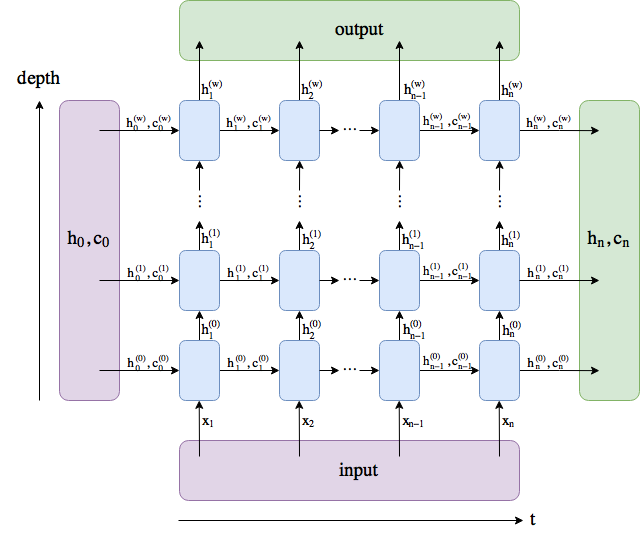


[source ](https://stackoverflow.com/questions/48302810/whats-the-difference-between-hidden-and-output-in-pytorch-lstm)

In [42]:
batch_size = 4  # per seq at once
seq_len = 8     # seq length (n - unrolling)
input_size = 5  # input feature/emb projection of each token (input to model)
hddn_size = 16  # dim of input neurons
n_layers = 2    # n of LSTM layer stacked

_input = torch.randn((batch_size, seq_len, input_size)) # B x T x C
lstm = nn.LSTM(input_size = input_size, hidden_size=hddn_size, num_layers=n_layers, batch_first=True) 

output, (h0, c0) = lstm(_input)
print(output.shape) # B x T x hddn_size
print(h0.shape) # n_layer x B x hddn_size
print(c0.shape) # n_layer x B x hddn_size

torch.Size([4, 8, 16])
torch.Size([2, 4, 16])
torch.Size([2, 4, 16])


#### Defining LSTM model

In [43]:
class LSTMNet(nn.Module):
    def __init__(self, emb_dim, hidden_size, vocab_size, n_layers, n_outs):
        super().__init__()
        self.emb_dim = emb_dim          # input to emb
        self.hidden_size = hidden_size  # LSTM internal NN size
        self.vocab_size = vocab_size    # len(tokenizer)
        self.n_layers = n_layers        # stacked lstm layers
        self.n_outs = n_outs            # output class

        ## project input
        self.embs = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.emb_dim)
        ## define lstm
        self.lstm = nn.LSTM(input_size=self.emb_dim, hidden_size=self.hidden_size,
                            num_layers=self.n_layers, batch_first=True)
        ## out classifier
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.hidden_size, self.n_outs)

    def forward(self, x):
        embs = self.embs(x)  # B x seq_len x emb_dim
        ## pass through lstm
        outputs, (hn, cn) = self.lstm(embs)
        # Take last out and return out class
        last_neuron = outputs[:, -1, :] # last step neuron ; B x hddn_size
        out = self.dropout(last_neuron)
        out = self.fc(out) # B x 1 x hddn -> B x vocab_size
        return out 
    
model = LSTMNet(emb_dim=8, hidden_size=10, vocab_size=len(w2i), n_layers=2, n_outs=2)
print(model)
for x, label in train_data_loader:
    print(x.shape, label.shape)
    outs = model(x)
    print(outs)
    break

LSTMNet(
  (embs): Embedding(992, 8)
  (lstm): LSTM(8, 10, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=10, out_features=2, bias=True)
)
torch.Size([16, 200]) torch.Size([16])
tensor([[0.3359, 0.3595],
        [0.2901, 0.3794],
        [0.2985, 0.3708],
        [0.2901, 0.3794],
        [0.2901, 0.3794],
        [0.2901, 0.3794],
        [0.2901, 0.3794],
        [0.2901, 0.3794],
        [0.2439, 0.3837],
        [0.3451, 0.3695],
        [0.2901, 0.3794],
        [0.2745, 0.3548],
        [0.2520, 0.3912],
        [0.2901, 0.3794],
        [0.2901, 0.3794],
        [0.2422, 0.3824]], grad_fn=<AddmmBackward0>)


#### Training

In [45]:
## define dataset
train_ds = IMDBDataLoader("../data/aclImdb/train", tokenizer=w2i)
val_ds = IMDBDataLoader("../data/aclImdb/test", tokenizer=w2i)
train_data_loader = DataLoader(dataset=train_ds, batch_size=128, shuffle=True, collate_fn=data_collator)
val_data_loader = DataLoader(val_ds, batch_size=128, shuffle=True, collate_fn=data_collator)

In [46]:
## defining pre-train
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
batch_size = 128

## model
model = LSTMNet(
    emb_dim=128,
    hidden_size=256,
    vocab_size=len(w2i), 
    n_layers=2,
    n_outs=2
)
model = model.to(DEVICE)
print(f"{model = }")

optm = optim.Adam(params=model.parameters(), lr=5e-4)
loss_fn = nn.CrossEntropyLoss()

Training on cpu
model = LSTMNet(
  (embs): Embedding(992, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [47]:
def train(epochs, model, train_data_loader, val_data_loader, optm, loss_fn):
    logs = {
        "epoch" : [],
        "training_loss": [],
        "val_loss": [],
        "training_acc": [],
        "val_acc": [],
    }
    save_path = "best_model.pt"
    best_val_loss = float('inf')

    for epoch in range(1, epochs+1):
        print(f"Epoch: {epoch}/ {epochs}")
        train_acc, val_acc, train_loss, val_loss = [], [], [], []

        model.train()
        for x, labels in tqdm(train_data_loader, desc = "Training"):
            ## data through model
            x, labels = x.to(DEVICE), labels.to(DEVICE)
            optm.zero_grad()
            outputs = model(x)

            ## calc acc
            preds = torch.argmax(outputs, axis=1)
            acc = ( (preds == labels).sum().float() )/ len(preds)
            train_acc.append(acc.item())

            ## Loss 
            loss = loss_fn(outputs, labels)
            train_loss.append(loss.item())
            loss.backward()

            ## clip exp gradiants
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            optm.step()

        model.eval()
        for x, labels in tqdm(val_data_loader, desc = "Validation"):
            ## data through model
            x, labels = x.to(DEVICE), labels.to(DEVICE)
            with torch.no_grad():
                ## forward
                outputs = model(x)

                ## calc acc
                preds = torch.argmax(outputs, axis=1)
                acc = ( (preds == labels).sum().float() )/ len(preds)
                val_acc.append(acc.item())

                ## Loss 
                loss = loss_fn(outputs, labels)
                val_loss.append(loss.item())

        logs["epoch"].append(epoch)
        logs["training_acc"].append(np.mean(train_acc))
        logs["val_acc"].append(np.mean(val_acc))
        logs["training_loss"].append(np.mean(train_loss))
        logs["val_loss"].append(np.mean(val_loss))

        print(
            f"Epoch {epoch} | "
            f"Train Loss: {logs['training_loss'][-1]:.4f} | Val Loss: {logs['val_loss'][-1]:.4f} | "
            f"Train Acc: {logs['training_acc'][-1]:.4f} | Val Acc: {logs['val_acc'][-1]:.4f}"
        )

    if logs["val_loss"][-1] < best_val_loss:
        best_val_loss = logs["val_loss"][-1]
        torch.save(model.state_dict(), save_path)
        print(f"Best model saved to {save_path}")

    return logs, model

In [ ]:
train_logs, model = train(
    epochs=15,
    model=model,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    optm=optm,
    loss_fn=loss_fn
)

torch.save(model.state_dict(), "final_model.pt")

- model training ran on kaggle and imported the model and logs

In [59]:
model.load_state_dict(torch.load("final_model.pt", map_location=torch.device(DEVICE)))
model.eval()

LSTMNet(
  (embs): Embedding(992, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

In [55]:
import json

train_logs = json.loads(open("train_logs.json").read())

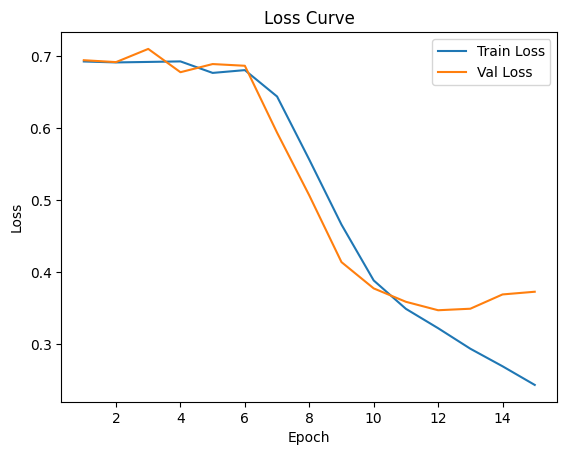

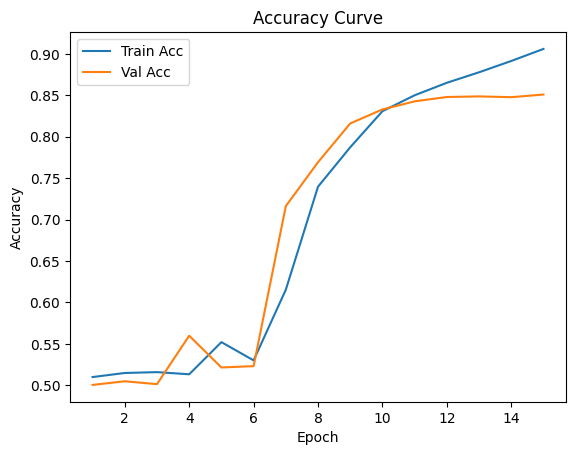

In [60]:
plt.plot(train_logs["epoch"], train_logs["training_loss"], label="Train Loss")
plt.plot(train_logs["epoch"], train_logs["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

plt.plot(train_logs["epoch"], train_logs["training_acc"], label="Train Acc")
plt.plot(train_logs["epoch"], train_logs["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()
